In [1]:
import numpy as np
import re 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as ins


In [9]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
df1=pd.read_csv("/kaggle/input/ag-news-classification-dataset/train.csv")

In [3]:
df1

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [4]:
df1["Class Index"].value_counts()

Class Index
3    30000
4    30000
2    30000
1    30000
Name: count, dtype: int64

In [ ]:
df2=pd.read_csv("/kaggle/input/ag-news-classification-dataset/test.csv")

# Preprocess the Text

In [7]:
df2["Description"][1]

'SPACE.com - TORONTO, Canada -- A second\\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\\privately funded suborbital space flight, has officially announced the first\\launch date for its manned rocket.'

In [10]:
df2["Description"][1]
t=word_tokenize(df2["Description"][1].lower())
t

['space.com',
 '-',
 'toronto',
 ',',
 'canada',
 '--',
 'a',
 'second\\team',
 'of',
 'rocketeers',
 'competing',
 'for',
 'the',
 '#',
 '36',
 ';',
 '10',
 'million',
 'ansari',
 'x',
 'prize',
 ',',
 'a',
 'contest',
 'for\\privately',
 'funded',
 'suborbital',
 'space',
 'flight',
 ',',
 'has',
 'officially',
 'announced',
 'the',
 'first\\launch',
 'date',
 'for',
 'its',
 'manned',
 'rocket',
 '.']

In [13]:
c=[lemmatizer.lemmatize(w) for w in t if w.isalpha() and w not in stop_words]
c

['toronto',
 'canada',
 'rocketeers',
 'competing',
 'million',
 'ansari',
 'x',
 'prize',
 'contest',
 'funded',
 'suborbital',
 'space',
 'flight',
 'officially',
 'announced',
 'date',
 'manned',
 'rocket']

In [12]:
stop_words=set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def process(text):
    tokens=word_tokenize(text.lower())
    cleaned = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return " ".join(cleaned)
df1["Description"]=df1["Description"].apply(process)
df2["Description"]=df2["Description"].apply(process)

In [14]:
df1["Description"].str.len().max()

670

# Feature Extraction using TF-IDF

In [15]:
data = pd.concat([df1 , df2] )

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=700)
vector_data = vectorizer.fit_transform(data['Description'])

In [15]:
vector_data 

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1155113 stored elements and shape (127600, 700)>

# Split dataset

In [17]:
from sklearn.model_selection import train_test_split

In [53]:
xtrain, xtest , ytrain , ytest = train_test_split(vector_data, data["Class Index"], train_size = .8 , stratify = data["Class Index"] )

# Train a XGboost model


In [54]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(ytrain)
y_test_enc = le.transform(ytest)


In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4
)

xgb_model.fit(xtrain, y_train_enc)


In [35]:
y_pred = xgb_model.predict(xtest)

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print(classification_report(y_test_enc, y_pred))


Accuracy: 0.8344043887147335
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      6380
           1       0.88      0.91      0.89      6380
           2       0.82      0.81      0.81      6380
           3       0.78      0.80      0.79      6380

    accuracy                           0.83     25520
   macro avg       0.83      0.83      0.83     25520
weighted avg       0.83      0.83      0.83     25520



# Train the Multinomial Naive Bayes Model

In [55]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(xtrain, y_train_enc)


MultinomialNB()

In [56]:
y_pred = nb_model.predict(xtest)

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print(classification_report(y_test_enc, y_pred))


Accuracy: 0.8299764890282132
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6380
           1       0.88      0.92      0.90      6380
           2       0.80      0.78      0.79      6380
           3       0.80      0.77      0.78      6380

    accuracy                           0.83     25520
   macro avg       0.83      0.83      0.83     25520
weighted avg       0.83      0.83      0.83     25520



# Visualize Most Frequent Words per Category

In [60]:
label_map = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tech"
}


In [61]:
data['Category_Name'] = data['Class Index'].map(label_map)


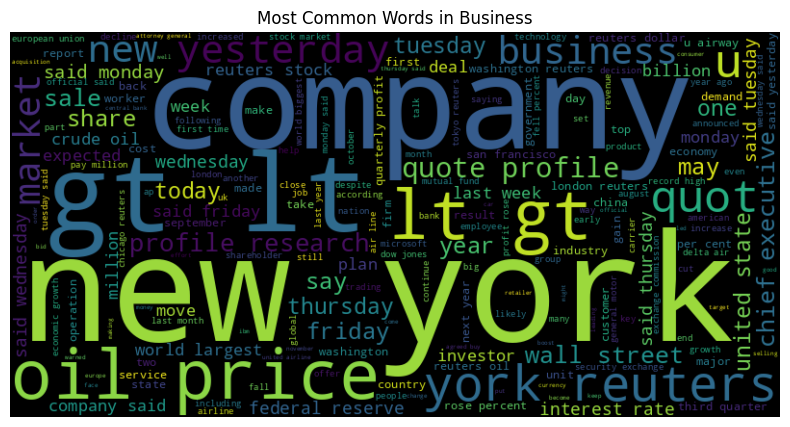

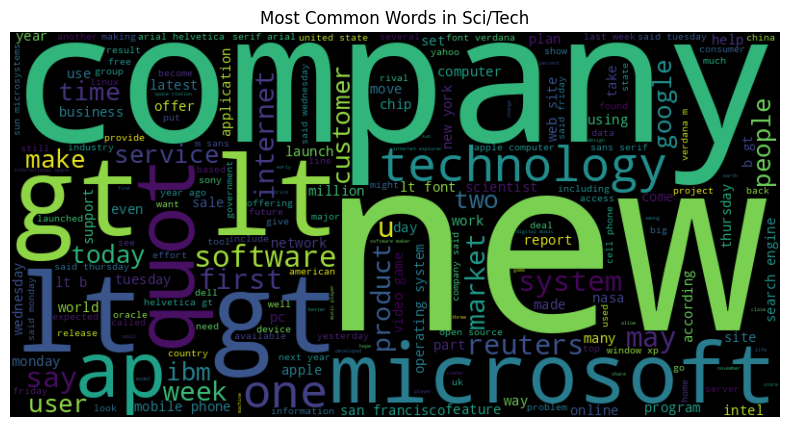

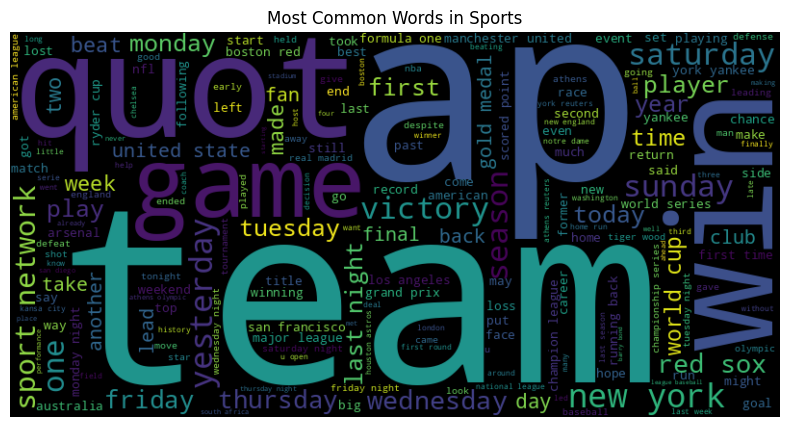

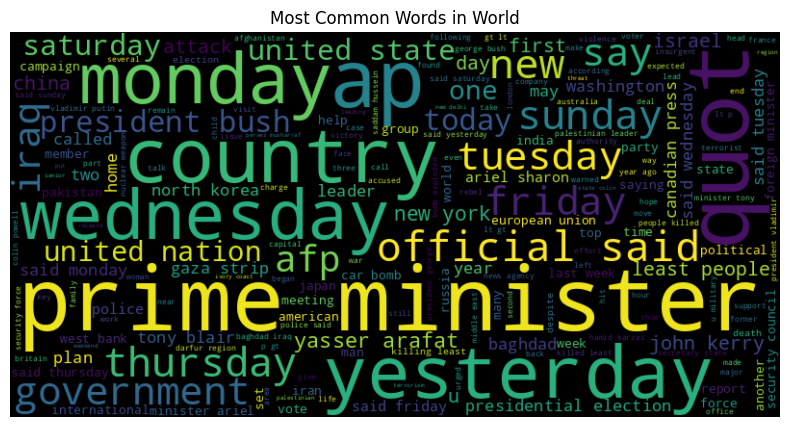

In [62]:
from wordcloud import WordCloud
categories = data['Category_Name'].unique()
for cat in categories:
    text = " ".join(data[data['Category_Name']== cat]['Description'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Common Words in {cat}')
    plt.show()
